## 1. Generate a small dataset of 2D feature vectors of two classes such that the classes are linearly separable. Similarly, generate an additional set with examples that are not separable.

In [32]:
import pandas as pd
import numpy as np
import pylab as pl
from pylab import*
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.datasets import make_moons, make_circles, make_classification

In [15]:
def lineardata(datasize = 200):
    # generate training data in the 2-d case
    size = datasize/2
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, size)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, size)
    y2 = np.ones(len(X2)) * -1
    X = np.append(X1, X2,axis = 0)
    y = np.append(y1,y2)
    return X,y

X [[-0.47301882  1.61222306]
 [-1.14903564  1.10141444]
 [-2.10815638 -0.26935975]
 [ 0.46790378  2.52917134]
 [ 1.65643548  2.47017508]]
y [ 1.  1.  1.  1.  1.]


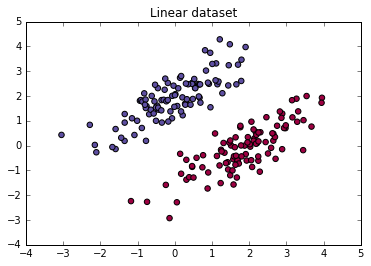

In [16]:
# Generate a linear dataset and plot it

X,y = lineardata()
plt.title("Linear dataset")
plt.scatter(X[:,0], X[:,1], s=30, c=y, cmap=plt.cm.Spectral)


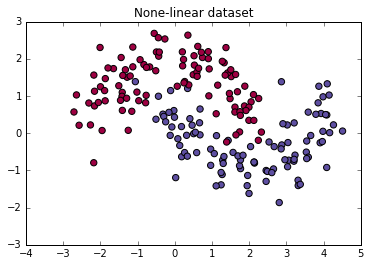

In [58]:
# Generate a non-linear dataset and plot it
def nonlineardata(size = 200):
    np.random.seed(0)
    X, y = sklearn.datasets.make_moons(size, noise=0.2)
    y[y == 0] = -1
    return X*2,y

X_nl, y_nl = nonlineardata()

plt.title("None-linear dataset")
plt.scatter(X_nl[:,0], X_nl[:,1], s=40, c=y_nl, cmap=plt.cm.Spectral)

## 2. Implement a linear SVM algorithm with hard margins and apply it to the separable dataset you generated. Plot the data points and mark the support vectors you identified. Apply the algorithm you implemented to the non-separable dataset and observe the results. Make sure to normalize the data if necessary (in this and subsequent algorithms you implement)

In [34]:
from array import array
from cvxopt import matrix,solvers

In [35]:

def fit(X,y,c=None):
    (m,n) = np.shape(X)

    if c is None:
        G = matrix(np.diag(np.ones(m) * -1))
        h = matrix(np.zeros(m))
    else:

        G0 = np.identity(m)
        G = matrix(np.append(-G0, G0,axis=0))
        
        h0 = np.zeros(m)
        h1 = np.empty(m)
        h1.fill(c)
        h = matrix(np.append(h0,h1))
        
    q = matrix(-np.ones(m))
    P = np.outer(y, y)*np.dot(X, X.T)
    P = matrix(P)
    A = matrix(y, (1,m),tc='d')
    b = matrix(0.0)


    sol=solvers.qp(P, q, G, h, A, b)
    a = np.ravel(sol['x'])
    return a


    



In [7]:
def getsv(X, y, a):
                
    idxa = a>1e-5
    idx = np.arange(len(a))[idxa]
    sva = a[idxa]
    svx = X[idxa]
    svy = y[idxa]
    nsv = len(sva)
    print "%d support vectors out of %d points" %(nsv,len(a))
    return sva,svx,svy

def getWb(sva, svx, svy):
    
    #weight
    
    w = np.empty(shape(X)[1])
    w = (sva*svy).dot(svx)
    
    # bias

    b = 0
    for n in range(0,len(sva)):
        b += svy[n]-np.dot(w[None],svx[n][None].T)
    b /= len(sva)
    return w, b


In [8]:
# K fold
def k_fold(size,k, shuffle = False):
    index = np.arange(0,size)
    if shuffle:
        np.random.shuffle(index)
    index = np.reshape(index, (k,size/k))
#     print index
    test = []
    train = []
    cursor = 0
    for i in range(0,k):
        test.append(index[i])
        temp = np.delete(index,i,0)
        train.append(temp.flatten())
    return test, train

In [76]:
def predict_helper(X_test, w, b):
    (m,n) = shape(X_test)    
    y_pre = b + dot(X_test,w[None].T)

    return y_pre
    
def predict(X_test, w, b):
    
    return np.sign(predict_helper(X_test, w, b))


In [ ]:
def plot_contour(X1_train, X2_train, clf):
    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.show()


In [77]:
def linearSVM(X,y, c = None):
    
    test, train = k_fold(len(y),5)
    X_test = X[test[0]]
    X_train = X[train[0]]
    y_test = y[test[0]]
    y_train = y[train[0]]
    a = fit(X_train,y_train, c)
    sva,svx,svy = getsv(X_train,y_train,a)
    w,b = getWb(sva,svx,svy)
    
    

    pre = predict(X_test,w,b)
    correct = np.sum(pre == y_test)
    print "%d out of %d predictions correct" % (correct, len(y_test))
    print 'accurcy of SVM is ',sum((y_test == pre))/float(len(y_test))
    
    plt.title("Dataset")
    plt.scatter(X_train[:,0], X_train[:,1], s=30, c=y_train,cmap=plt.cm.Spectral)
    plt.scatter(svx[:,0], svx[:,1], s = 40, c = "g")
    X1, X2 = np.meshgrid(np.linspace(-4,5,50), np.linspace(-4,5,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = predict_helper(X,w,b).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    return None




### 2.1 linear SVM algorithm with hard margins and apply it to the separable dataset 

Linear dataset: 
     pcost       dcost       gap    pres   dres
 0: -1.4788e+01 -2.8329e+01  5e+02  2e+01  2e+00
 1: -1.9444e+01 -1.0170e+01  1e+02  4e+00  4e-01
 2: -1.7980e+01 -7.4445e+00  7e+01  2e+00  2e-01
 3: -4.7076e+00 -4.0608e+00  1e+01  3e-01  3e-02
 4: -2.7162e+00 -3.4819e+00  2e+00  2e-02  2e-03
 5: -3.0887e+00 -3.3929e+00  3e-01  1e-03  9e-05
 6: -3.3671e+00 -3.3704e+00  4e-03  1e-05  1e-06
 7: -3.3701e+00 -3.3701e+00  4e-05  1e-07  1e-08
 8: -3.3701e+00 -3.3701e+00  4e-07  1e-09  1e-10
Optimal solution found.
3 support vectors out of 160 points
1560 out of 40 predictions correct
accurcy of SVM is  39.0


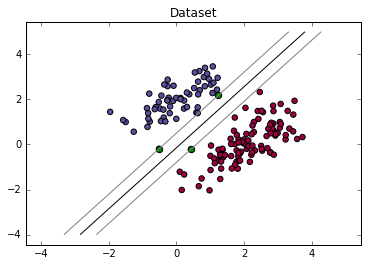

In [78]:
X,y = lineardata()
print "Linear dataset: "
linearSVM(X,y)

#### In linearly separable data, The accurcy of SVM of hard Margine works well.  


### 2.2 linear SVM algorithm with hard margins and apply it to the non-separable dataset 

Non-linear dataset:
     pcost       dcost       gap    pres   dres
 0: -6.2082e+01 -1.7655e+02  7e+02  2e+01  3e+00
 1: -2.4715e+02 -5.0497e+02  6e+02  1e+01  2e+00
 2: -1.0888e+03 -1.4693e+03  4e+02  1e+01  1e+00
 3: -2.6478e+03 -3.2418e+03  6e+02  9e+00  1e+00
 4: -9.8628e+03 -1.1002e+04  1e+03  8e+00  1e+00
 5: -8.3227e+04 -8.5439e+04  2e+03  7e+00  1e+00
 6: -1.6494e+06 -1.6719e+06  2e+04  7e+00  1e+00
 7: -1.0235e+08 -1.0260e+08  2e+05  7e+00  1e+00
 8: -3.8835e+10 -3.8842e+10  8e+06  7e+00  1e+00
 9: -5.3094e+10 -5.3105e+10  1e+07  7e+00  1e+00
10: -5.6323e+10 -5.6334e+10  1e+07  7e+00  1e+00
11: -2.6109e+11 -2.6114e+11  5e+07  7e+00  1e+00
12: -4.9295e+11 -4.9305e+11  1e+08  7e+00  1e+00
Terminated (singular KKT matrix).
160 support vectors out of 160 points
18 out of 40 predictions correct
accurcy of SVM is  0.45


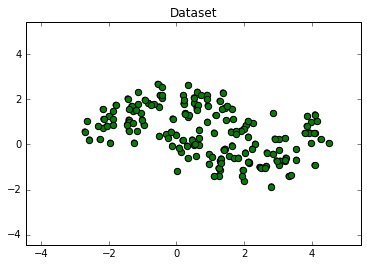

In [59]:
X_nl, y_nl = nonlineardata()
print "Non-linear dataset:"
linearSVM(X_nl,y_nl)

#### In non-linearly separable data, The accurcy of SVM of hard Margine is only 0.45.  
#### In train dataset, it considered all data as support vector.  

### This means in non-linearly separable dataset, hard margine of linear SVM doesn't work well.

## 4. Implement a linear SVM algorithm with soft margins and apply it to the datasets you generated. Plot the data points and mark the support vectors you identified.

#### For separable dataset:

Linear dataset: 
     pcost       dcost       gap    pres   dres
 0: -7.5792e+00 -2.3192e+01  7e+02  2e+01  3e-15
 1: -1.5354e+00 -2.0685e+01  4e+01  8e-01  3e-15
 2: -5.7767e-01 -5.3147e+00  5e+00  3e-02  1e-15
 3: -7.7080e-01 -1.7381e+00  1e+00  5e-03  1e-15
 4: -9.0921e-01 -1.2803e+00  4e-01  1e-03  8e-16
 5: -9.7394e-01 -1.1126e+00  1e-01  4e-04  1e-15
 6: -1.0013e+00 -1.0502e+00  5e-02  1e-04  9e-16
 7: -1.0120e+00 -1.0281e+00  2e-02  3e-05  1e-15
 8: -1.0160e+00 -1.0202e+00  4e-03  6e-16  1e-15
 9: -1.0180e+00 -1.0180e+00  5e-05  2e-16  1e-15
10: -1.0180e+00 -1.0180e+00  5e-07  2e-16  1e-15
Optimal solution found.
18 support vectors out of 160 points
40 out of 40 predictions correct
accurcy of SVM is  1.0


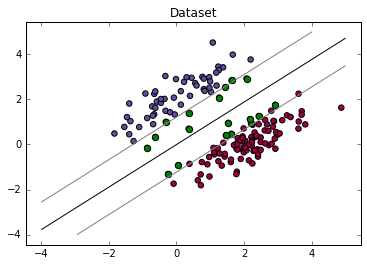

In [61]:
X,y = lineardata()
print "Linear dataset: "
linearSVM(X,y,0.1)

Apply softemargins on the same linear-separable dataset, the margin is bigger than hard margin.

### For non-separable dataset

Non-linear separable dataset:
     pcost       dcost       gap    pres   dres
 0: -3.4217e+01 -3.4157e+01  1e+03  3e+01  3e-15
 1: -5.5039e+00 -3.1974e+01  6e+01  8e-01  3e-15
 2: -4.1668e+00 -1.1741e+01  8e+00  2e-16  1e-15
 3: -4.9450e+00 -6.3450e+00  1e+00  2e-16  9e-16
 4: -5.2924e+00 -5.7254e+00  4e-01  5e-16  1e-15
 5: -5.3900e+00 -5.5695e+00  2e-01  2e-16  1e-15
 6: -5.4480e+00 -5.4775e+00  3e-02  2e-16  1e-15
 7: -5.4589e+00 -5.4628e+00  4e-03  2e-16  1e-15
 8: -5.4606e+00 -5.4606e+00  5e-05  2e-16  1e-15
 9: -5.4606e+00 -5.4606e+00  5e-07  2e-16  1e-15
Optimal solution found.
61 support vectors out of 160 points
30 out of 40 predictions correct
accurcy of SVM is  0.75


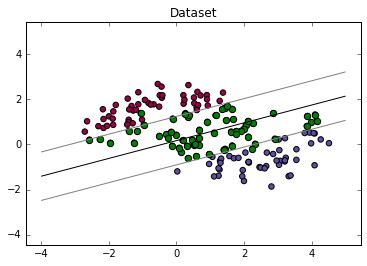

In [65]:
print "Non-linear separable dataset:"
linearSVM(X_nl,y_nl,0.1)

#### After several try to find the best C, I found that when C = 0.1, the accuracy is best, and with soft margine, linear SVM works a little bit better than hard margin on non-seperable dataset, even the accurcy is still unideality

## 5. Implement a kernel-based SVM algorithm using a polynomial and Gaussian kernel functions. Apply your implementation to the datasets you generated. Plot the support vectors you obtain. Test the algorithm on two additional external datasets and report performance. Test and explain the effect of modifying different parameters of the algorithm. 

In [66]:
def linear(x1, x2):
    return np.dot(x1, x2)

def polynomial(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [129]:
# Gram matrix
def gram(X, kernel = linear):

    (m,n) = np.shape(X)
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if kernel is polynomial:
                K[i,j] = polynomial(X[i], X[j])
            elif kernel is gaussian: 
                K[i,j] = gaussian(X[i], X[j])
            else:
                K[i,j] = linear(X[i],X[j])
                
    return K


def k_fit(X,y,c=None, kernel = linear):
    (m,n) = np.shape(X)
    
    K = gram(X, kernel)

    if c is None:
        G = matrix(np.diag(np.ones(m) * -1))
        h = matrix(np.zeros(m))
    else:

        G0 = np.identity(m)
        G = matrix(np.append(-G0, G0,axis=0))
        
        h0 = np.zeros(m)
        h1 = np.empty(m)
        h1.fill(c)
        h = matrix(np.append(h0,h1))
        
    q = matrix(-np.ones(m))
    P = matrix(np.outer(y, y) * K)
    P = matrix(P)
    A = matrix(y, (1,m),tc='d')
    b = matrix(0.0)


    sol=solvers.qp(P, q, G, h, A, b)
    a = np.ravel(sol['x'])
    
    
    # compute weight and bias
    
    idxa = a>1e-5
    idx = np.arange(len(a))[idxa]
    sva = a[idxa]
    svx = X[idxa]
    svy = y[idxa]
    nsv = len(sva)
    print "%d support vectors out of %d points" %(nsv,len(a))

    if kernel is linear:
        w = np.empty(shape(X)[1])
        w = (sva*svy).dot(svx)
    else: 
        w = None
        
    b = 0
    for n in range(0, nsv):
        b += svy[n]
        b -= np.sum(sva*svy* K[idx[n],idxa])
    b /= nsv
    
#             self.b = 0
#         for n in range(len(self.a)):
#             self.b += self.sv_y[n]
#             self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
#         self.b /= len(self.a)
    
    
    return (sva,svx,svy,w,b)


In [135]:
def k_predict(X_test, sva, svx, svy, w, b, kernel):
    m = len(X_test)
    if w is not None:
        return b + dot(X_test,w[None].T)
    else:
        y_predict = np.zeros(m)
        for i in range(0, m):
            s = 0
            for a, sv_y, sv in zip(sva, svy, svx):
#                 print 'x[i]', X_test[i]
                if kernel == linear:
                    k = linear(X_test[i], sv)
                elif kernel == gaussian:
                    k = gaussian(X_test[i], sv)
                else:
                    k = polynomial(X_test[i], sv)
                s += a * sv_y * k
                y_predict[i] = s
        return y_predict + b
    
    
    
    
#     def project(self, X):
#         if self.w is not None:
#             return np.dot(X, self.w) + self.b
#         else:
#             y_predict = np.zeros(len(X))
#             for i in range(len(X)):
#                 s = 0
#                 for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
#                     s += a * sv_y * self.kernel(X[i], sv)
#                 y_predict[i] = s
#             return y_predict + self.b

In [138]:
def Kernel_SVM(X,y, c = None, kernel = linear):
    
    test, train = k_fold(len(y),5)
    X_test = X[test[0]]
    X_train = X[train[0]]
    y_test = y[test[0]]
    y_train = y[train[0]]
    
    K = gram(X_train, kernel)
    t = k_fit(X_train,y_train,c, kernel)
    sva = t[0]
    svx = t[1]
    svy = t[2]
    w = t[3]
    b = t[4]
#     (sva,svx,svy,w,b) = t
    
    predict = k_predict(X_test, sva, svx, svy, w, b, kernel)
    

    pre = np.sign(predict)
    correct = np.sum(pre == y_test)
    print "%d out of %d predictions correct" % (correct, len(y_test))
    print 'accurcy of SVM is ',sum((y_test == pre))/float(len(y_test))
    
    plt.title("Dataset")
    plt.scatter(X_train[:,0], X_train[:,1], s=30, c=y_train,cmap=plt.cm.Spectral)
    plt.scatter(svx[:,0], svx[:,1], s = 40, c = "g")
    X1, X2 = np.meshgrid(np.linspace(-4,5,50), np.linspace(-4,5,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = k_predict(X, sva, svx, svy, w, b, kernel).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    return None




Linear dataset: 
     pcost       dcost       gap    pres   dres
 0: -3.2858e+00 -2.2298e+01  6e+02  2e+01  1e-13
 1: -7.0476e-01 -1.9653e+01  3e+01  4e-01  1e-13
 2: -5.0030e-01 -7.8974e+00  1e+01  1e-01  3e-14
 3: -4.1805e-01 -4.0841e+00  5e+00  6e-02  2e-14
 4: -3.8848e-01 -2.0342e+00  2e+00  3e-02  1e-14
 5: -3.3154e-01 -1.4105e+00  2e+00  1e-02  9e-15
 6: -2.3059e-01 -9.7767e-01  1e+00  7e-03  6e-15
 7: -2.4553e-01 -3.8806e-01  2e-01  1e-03  3e-15
 8: -2.5044e-01 -3.4084e-01  1e-01  4e-04  3e-15
 9: -2.6966e-01 -2.8165e-01  1e-02  4e-05  3e-15
10: -2.7313e-01 -2.7431e-01  1e-03  4e-06  3e-15
11: -2.7352e-01 -2.7354e-01  2e-05  5e-08  3e-15
12: -2.7353e-01 -2.7353e-01  2e-07  5e-10  3e-15
Optimal solution found.
8 support vectors out of 160 points
40 out of 40 predictions correct
accurcy of SVM is  1.0


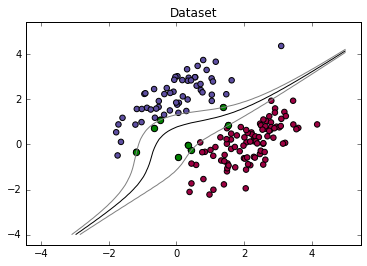

In [139]:
X,y = lineardata()
print "Linear dataset: "
Kernel_SVM(X,y,0.1, polynomial)